In [4]:
%load_ext autoreload
%autoreload 2
import sys 
from os import path as pt

sys.path.append('../src')   
import seaborn as sns
sns.set_theme()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import os 
model_dir = "../trained_models/BSprice_timestep_60/model_BetaCVAE_De_CLSTMRes_En_CLSTMRes_Prior_RealNVP_Con_Id_Dis_None_comment_None/BetaCVAE_training_2024-08-14_14-58-49/final_model"
os.makedirs(model_dir,exist_ok=True)

In [6]:
from evaluations.hyperparameter import ModelEvaluator
from tsvae.utils.random_utils import set_seed
model_evaluator = ModelEvaluator(model_dir)
output_dir = model_evaluator.hyper_model_dir
model = model_evaluator.model

test_data, gen_data, recon_data = model_evaluator.load_data(seed = 99)
ds = model_evaluator.data_ppl.base_dataset

real_data = test_data
recon_data = recon_data
fake_data = gen_data

Base dataset initialized


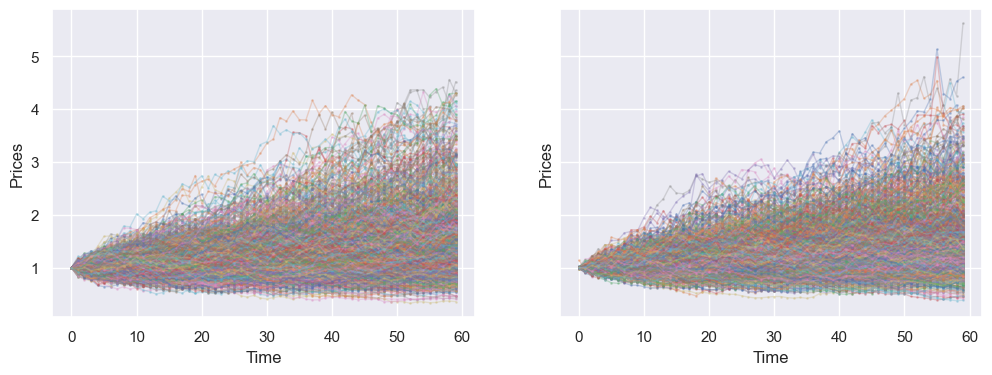

In [7]:
from evaluations.compare import compare_path
compare_path(real_data,fake_data)

In [5]:
from evaluations.compare import compare_corr, compare_path, compare_marginal_hist, compare_noised_paths
import seaborn as sns 
sns.set_theme()

file_path = pt.join(output_dir, 'prices_real_fake.png')
compare_path(real_data, fake_data, ['Real', 'Fake'], file_path)
 
file_path = pt.join(output_dir, 'prices_real_recon.png')
compare_path(real_data, recon_data, ['Real', 'Recon'], file_path)

file_path = pt.join(output_dir, 'marginal_real_fake.png')
compare_marginal_hist(real_data, fake_data, file_path = file_path)

file_path = pt.join(output_dir, 'correlation.png')
compare_corr(real_data, fake_data, file_path=file_path)


(tensor(1.), tensor(1.))

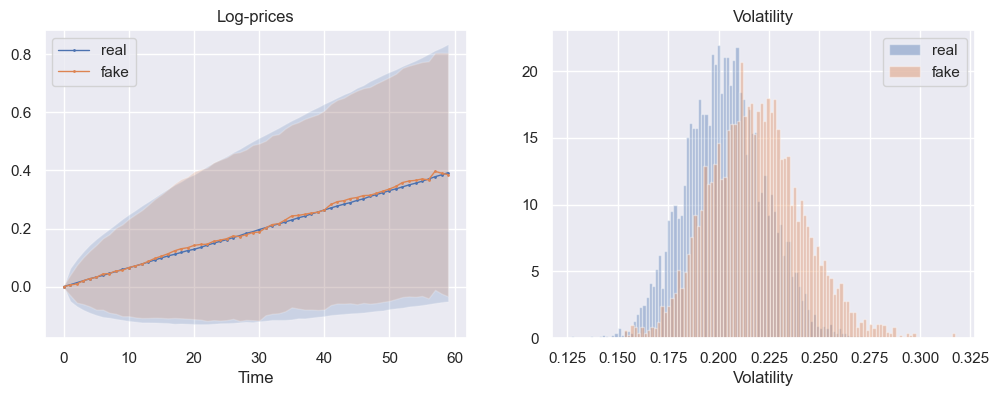

In [6]:
from evaluations.eval_drift_vol import compare_drift_volatility
file_path = pt.join(output_dir, 'drift_volatility.png')
compare_drift_volatility(real_data, fake_data, T = ds.dt * ds.n_timestep, file_path = file_path)

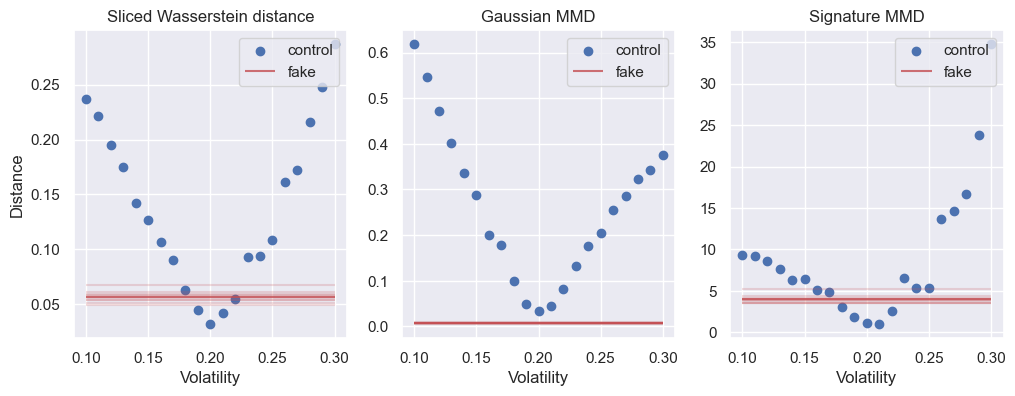

In [9]:
from evaluations.eval_uncon import load_data_eval_dist_uncon, compute_eval_dist_uncon, plot_eval_dist_uncon
fake_data_list, control_data_dict = load_data_eval_dist_uncon(model_evaluator)

mmd_control_dist, mmd_fake_dist = compute_eval_dist_uncon(real_data, fake_data_list, control_data_dict, 'mmd', output_dir)
swd_control_dist, swd_fake_dist = compute_eval_dist_uncon(real_data, fake_data_list, control_data_dict, 'swd', output_dir)
esig_control_dist, esig_fake_dist = compute_eval_dist_uncon(real_data, fake_data_list, control_data_dict, 'esig', output_dir)

file_path = pt.join(output_dir, 'mmd_swd_esig.png')
plot_eval_dist_uncon(
    mmd_control_dist,
    mmd_fake_dist,
    swd_control_dist,
    swd_fake_dist,
    esig_control_dist,
    esig_fake_dist,
    plot_file_path=file_path,
)

100%|██████████| 5/5 [00:16<00:00,  3.36s/it]


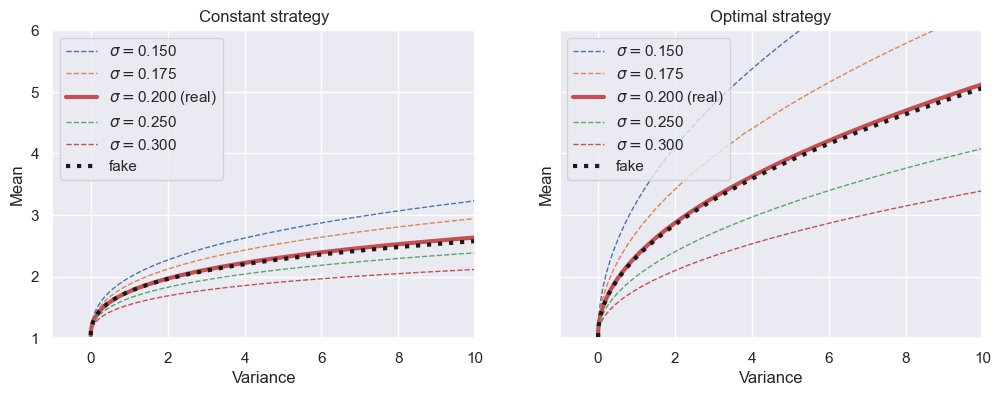

In [8]:
from evaluations.eval_mv import compute_mean_variance, plot_mean_variance
real_sigma = ds.sigma
file_path = pt.join(output_dir, 'mean_variance_portfolio.png')
sigma_strategy_dict, sigma_strategy_dict_data = compute_mean_variance(model_evaluator, real_data)
plot_mean_variance(sigma_strategy_dict, sigma_strategy_dict_data, real_sigma, file_path = file_path)

Loading data


100%|██████████| 1/1 [00:00<00:00,  6.11it/s]


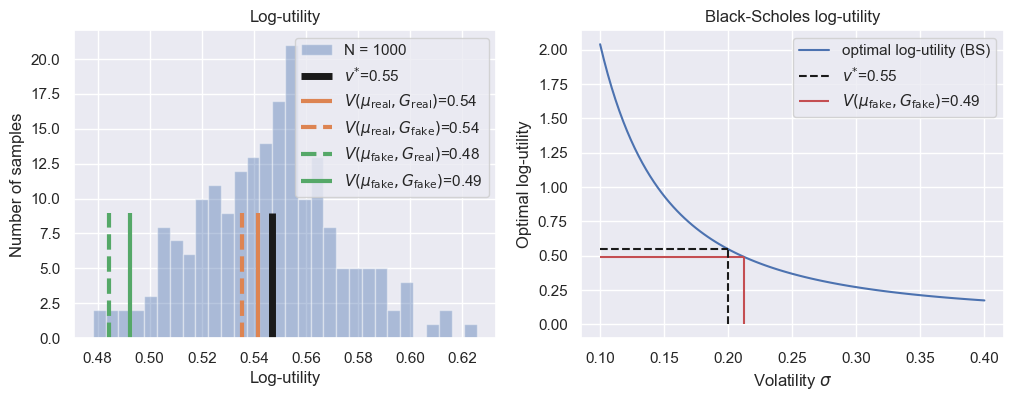

In [9]:
from evaluations.eval_log_utility import compare_log_utility_max
file_path = pt.join(output_dir, 'log_utility.png')
compare_log_utility_max(model_evaluator, file_path=file_path)

100%|██████████| 21/21 [00:18<00:00,  1.15it/s]


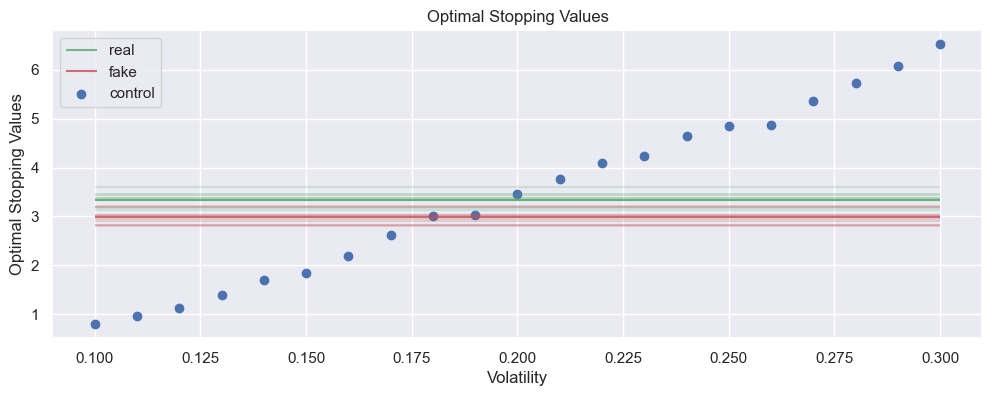

In [10]:
from evaluations.eval_os import load_os_data, compare_os
r = ds.mu
dt = ds.dt
s0, strike = 100, 100
n_maturity_timestep = 12
n_sample_test = 5000

real_data_list, fake_data_list, control_data_dict = load_os_data(model_evaluator, s0, n_maturity_timestep, n_sample_test)
file_path = pt.join(output_dir, 'optimal_stopping.png')
compare_os(r,s0,n_maturity_timestep,dt,strike,real_data_list,fake_data_list,control_data_dict,file_path=file_path)

In [11]:
from copy import deepcopy
from evaluations.eval_uncon import compute_eval_awd_dist_uncon, plot_eval_awd_dist_uncon
sigma = 0.3
exp_config = deepcopy(model_evaluator.exp_config)
exp_config.n_sample = len(real_data)
control_data, label = model_evaluator.data_ppl._get_data_label(exp_config, control = sigma)

realreal
mean: 0.3546375880527323
std: 0.02127732511605735
realfake
mean: 0.3623709905450277
std: 0.03373156962879162
realcontrol
mean: 0.6419092540511065
std: 0.05536513497510214


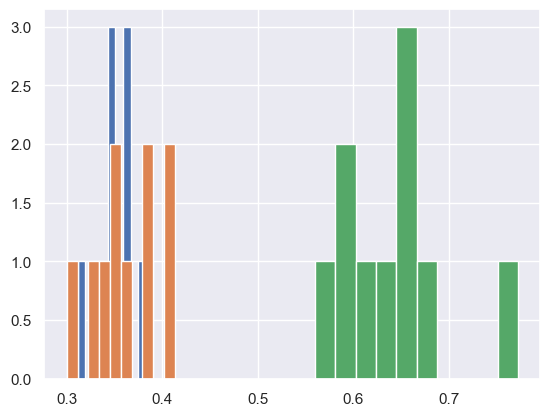

In [12]:
sawd_dist_dict = compute_eval_awd_dist_uncon(real_data, fake_data, control_data, output_dir)
plot_eval_awd_dist_uncon(sawd_dist_dict, output_dir)